# **PokeGen**


#Abstract

The current research developed, analyzed, and compared a Variational Autoencoder (VAE) and a Generative Adversarial Network (GAN) in terms of structure, strengths, weaknesses, and performance characteristics. Specifically, we will looked at the generation of images similar to “Pokémon” given the models’ proper development and training. The main findings are that for image generation, the implementation of VAE vs GAN is ultimately up to user preference. The VAE is more accurate in its reconstruction of Pokémon, while the GAN is more creative in generating unseen images. While the models could not produce perfect output, it is possible they can be used to at least offer inspiration to human artists in their creation of new Pokémon.

#Introduction

When people think of “generative AI”, most probably think of ChatGPT and other large language models. However, the generation of realistic images through artificial intelligence is on the rise and has become a critical area of research and development not only in the computer science field, but also in pop culture. Various machine learning models have been developed for image generation, including Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs). The current research aims to develop, compare, and analyze the VAE vs GAN models in terms of structure, strengths, weaknesses, and performance characteristics. Specifically, we will look at the generation of images similar to “Pokémon” given the models’ proper development and training.

# Dataset

The dataset can be downloaded through Kaggle at this link: https://www.kaggle.com/datasets/hlrhegemony/pokemon-image-dataset

The dataset includes 2503 images of all Pokemon from generations 1-8, including their gigantamax, mega evolution, Alolan, and Galarian forms. The backgrounds of each image were uniform and all white.

The images in the dataset were extracted from their class folders and brought up to the root folder (here, called "pokemonallimages") using a python script. Make sure to have the dataset in the same directory as this notebook.

In [ ]:
# We saved our data set in a google drive; this cell allows colab access to the current user's drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
from PIL import Image

_root = '/content/drive/MyDrive/images'
filenames = sorted(os.listdir(_root))
images = []

for fname in filenames:
    path = os.path.join(_root, fname)
    image = Image.open(path)
    # Resize the image to the common shape
    image = image.resize((120,120))
    # Convert the resized image to a numpy array
    image_array = np.array(image, dtype=np.float32)
    images.append(image_array)

# Convert the list of images to a numpy array
images = np.array(images)

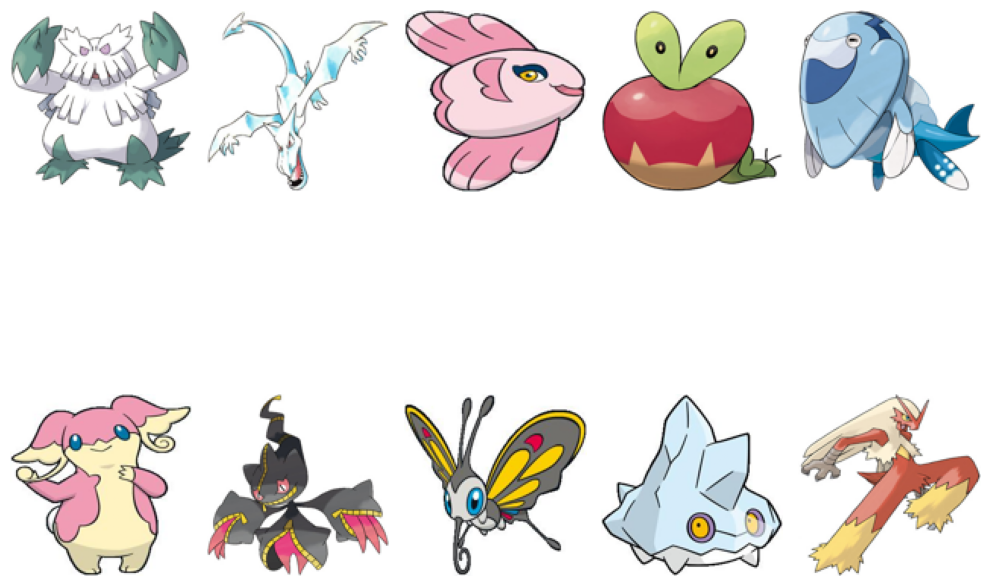

In [ ]:
# A sample of 10 images
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(10, 10))

for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(images[i*20, :, :, :] / 255.)
    ax.axis('off')

plt.tight_layout()
plt.show()

#Methodology

Both Variational Autoencoders (VAE) and Generative Adversarial Networks (GAN) have two key parts that work together to generate quality images, eventually generating a new image from an input of noise.

**VAE:** The main principle behind the VAE is that an encoder and a decoder piece will work together to deconstruct and reconstruct training data. The encoder will take a training image and add noise to it, then challenge the decoder to "denoisify" or reconstruct the original image. Eventually the decoder adds more and more noise until the decoder can satisfactorily take in utter gibberish noise as an input and "reconstruct the original image" out of that. This effectively amounts to our VAE imagining what it thinks a Pokemon that was "noisified" like that should have originally looked like.

**GAN:** GANs are adversarial by nature, which means the primary learning comes from trying to break the model. This method is achieved by another two-part system: the generator and the discriminator. The generator continuously throw an image at the discriminator, who will then try to determine whether the image it received was genuine (straight from the training data) or fake (newly generated by the generator). Each volley will backpropagate to tweak the generator, with the idea that eventually the discriminator will fail to accurately identify the fake images an acceptable percentage of the time. Once this is achieved, our generator can then be reliably asked to "generate a fake image" which should resemble a Pokemon-like entity.

## Variational Autoencoder (VAE)

This VAE is an adjusted form of this one: https://www.kaggle.com/code/rimbax/convolutional-vae-with-pokemon-images

The original VAE was tailored for MNIST, but was adjusted to fit the dataset that we used for the GAN as well.

In [ ]:
!pip install -q tensorflow-probability

!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import random
from sklearn.model_selection import train_test_split

In [ ]:
import shutil
train_filenames, test_filenames = train_test_split(os.listdir(_root), test_size=0.2, random_state=42)
train_dir = 'train_data'
test_dir = 'test_data'
# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move training images to train directory
for filename in train_filenames:
    src_path = os.path.join(_root, filename)
    dst_path = os.path.join(train_dir, filename)
    shutil.copy(src_path, dst_path)
# Move testing images to test directory
for filename in test_filenames:
    src_path = os.path.join(_root, filename)
    dst_path = os.path.join(test_dir, filename)
    shutil.copy(src_path, dst_path)

# Boolean encodings that indicate whether filenames[i] belong to training or testing
train_mask = np.isin(filenames, train_filenames)
test_mask  = np.isin(filenames, test_filenames)

In [ ]:
#Segregate actual images to their proper lists, as encoded by the masks
train_images, test_images = images[train_mask], images[test_mask]

In [ ]:
def preprocess_images(images):
    images = tf.image.resize(images, (32, 32)) / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

print(train_images.shape)
print(test_images.shape)

(2002, 32, 32, 3)
(501, 32, 32, 3)


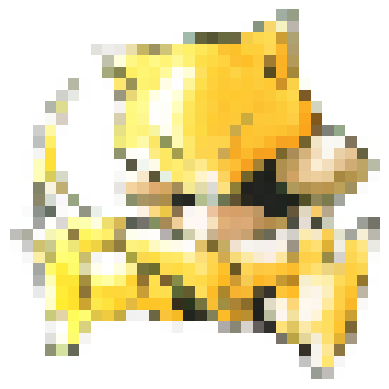

In [ ]:
plt.imshow(test_images[2], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
train_size = train_images.shape[0]
batch_size = 64
test_size = test_images.shape[0]

### Use *tf.data* to batch and shuffle the data

In [ ]:
import tensorflow as tf

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

### Define the encoder and decoder networks

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB2

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=train_images.shape[1:]),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=7, strides=(2, 2), activation='relu', padding='same'
            ),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=5, strides=(2, 2), activation='relu', padding='same'
            ),
            tf.keras.layers.Conv2D(
                filters=16, kernel_size=5, strides=(2, 2), activation='relu', padding='same'
            ),
            tf.keras.layers.Conv2D(
                filters=8, kernel_size=3, strides=(2, 2), activation='relu', padding='same'
            ),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(4, 4, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=5, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=5, strides=1, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=5, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=1, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=16, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
model = CVAE(latent_dim=4)
model.encoder.summary()
model.decoder.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 16, 16, 64)        9472      
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 32)          51232     
                                                                 
 conv2d_30 (Conv2D)          (None, 4, 4, 16)          12816     
                                                                 
 conv2d_31 (Conv2D)          (None, 2, 2, 8)           1160      
                                                                 
 flatten_7 (Flatten)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 8)                 264       
                                                                 
Total params: 74944 (292.75 KB)
Trainable params: 749

### Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here, plot the probabilities of Bernoulli distributions


In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

In [ ]:
epochs = 10000
epoch_when_max_lr = 1000
epochs_for_max_lr = 1000
init_lr, max_lr, final_lr = 1e-5, 1e-3, 1e-6

steps_per_epoch = int(np.round(train_images.shape[0] / batch_size))
step_when_max_lr = epoch_when_max_lr * steps_per_epoch
steps_for_max_lr = epochs_for_max_lr * steps_per_epoch
total_steps = epochs * steps_per_epoch

print('Steps per epoch:', steps_per_epoch)
print('Step when max LR:', step_when_max_lr)
print('Steps for max LR:', steps_for_max_lr)
print('Total steps:', total_steps)

optimizer = tf.keras.optimizers.legacy.Adam(init_lr)

# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Steps per epoch: 31
Step when max LR: 31000
Steps for max LR: 31000
Total steps: 310000


Epoch: 10000, Test set ELBO: -1803.73828125, time per epoch: 0.15390849113464355, lr: 0.000010


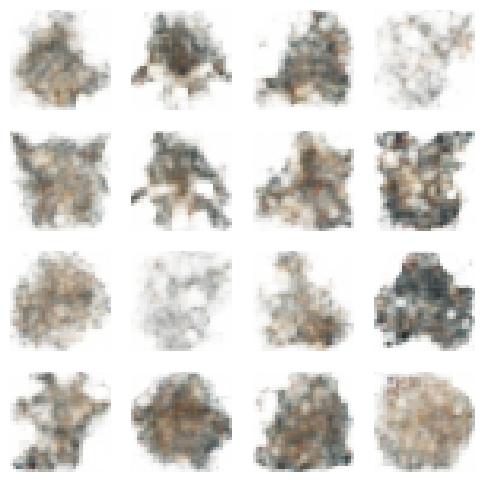

In [ ]:
generate_and_save_images(model, 0, test_sample)

total_steps = 0
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
    total_steps += 1

    if total_steps <= step_when_max_lr:
      new_lr = init_lr + total_steps * (max_lr - init_lr) / step_when_max_lr
    elif total_steps <= step_when_max_lr + steps_for_max_lr:
      new_lr = max_lr
    elif total_steps % 10 == 0:
      new_lr = max_lr - (total_steps // 10) * 1e-6
      new_lr = max(1e-5, new_lr)
    optimizer.learning_rate.assign(new_lr)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()

  if epoch % 100 == 0:
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time per epoch: {}, lr: {:.6f}'
            .format(epoch, elbo, end_time - start_time, optimizer.learning_rate.numpy()))
    generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 599.5, 599.5, -0.5)

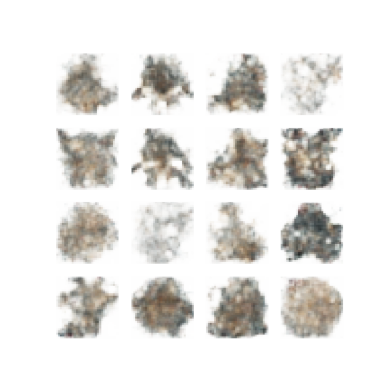

In [ ]:
plt.imshow(display_image(10000))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)[:-5]
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-56-224c6d4c0c81>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-56-224c6d4c0c81>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



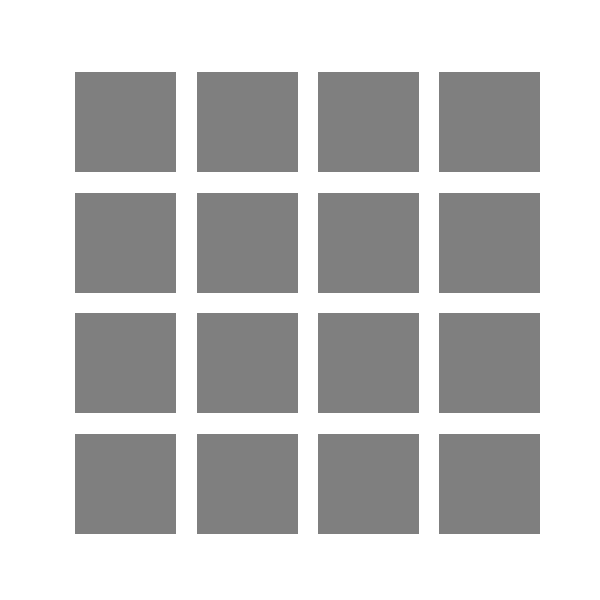

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [ ]:
def plot_latent_images(model, n, digit_size=50):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width, 4))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size, 4))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size, :] = digit.numpy()

  fig, ax = plt.subplots(figsize=(10, 10))
  ax.imshow(image)
  ax.axis('Off')
  return fig, ax

In [ ]:
fig, ax = plot_latent_images(model, 10, digit_size=32)
plt.show()

In [ ]:
import imageio.v2 as imageio
import numpy as np

# Read in the two .gif files as numpy arrays
image1 = imageio.imread("download.gif")
image2 = imageio.imread("download (1).gif")

# Make sure both images have the same height
image1 = np.tile(image1[:, :, np.newaxis], (1, 1, 4))
if image1.shape[0] != image2.shape[0]:
    raise ValueError("Images have different heights")

# Concatenate the two images horizontally using numpy's hstack function
side_by_side = np.hstack((image1, image2))

# Save the resulting image as a new .gif file
imageio.imwrite("side_by_side.gif", side_by_side, format="gif")


In [ ]:
image1.shape

##Generational Adversarial Network

This GAN is an adjusted form of this one: https://medium.com/@jkleiber8/pokegan-generating-fake-pokemon-with-a-generative-adversarial-network-f540db81548d

In [ ]:
!pip install torch
!pip install tqdm
!pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image

Running on GPU will help train the model faster.

In [ ]:
# Set the multiprocessing start method to 'spawn'
mp.set_start_method('spawn', force=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, device='cuda'):
        self.root_dir = root_dir
        self.transform = transform
        self.device = device
        self.images = os.listdir(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image.to(self.device)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),         # Convert images to PyTorch tensors
])

dataset = CustomDataset(root_dir=_root, transform=transform)
batch_size = 16
num_workers = 0
pin_memory = False
shuffle = True

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin_memory)

###Visualize the data

In [ ]:
for batch in dataloader:
    # Convert images to CPU and numpy arrays for visualization
    images = batch.cpu().numpy()

    # Plot the images
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for ax, img in zip(axes, images):
        ax.imshow(img.transpose((1, 2, 0)))  # Assuming images are in CHW format
        ax.axis('off')
    plt.show()
    # Put the images back to gpu
    images = batch.to(device)
    break

###Discriminator

In [ ]:
disc = nn.Sequential(
    # Input is 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 16 x 16

    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 8 x 8

    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # Layer Output: 128 x 4 x 4

    # With a 4x4, we can condense the channels into a 1 x 1 x 1 to produce output
    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

disc = disc.to(device)
# Make sure all parameters of the model are also on the same device (cuda:0)
for param in disc.parameters():
    param = param.to(device)
for name, param in disc.named_parameters():
    print(f"Parameter '{name}' on device: {param.device}")

###Generator

In [ ]:
seed_size = 100
gen = nn.Sequential(
    # Input seed_size x 1 x 1
    nn.ConvTranspose2d(seed_size, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 256 x 4 x 4

    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 128 x 8 x 8

    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # Layer output: 64 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # Layer output: 32 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
    # Output: 3 x 64 x 64
)
gen = gen.to(device)
# Make sure all parameters of the model are also on the same device (cuda:0)
for param in gen.parameters():
    param = param.to(device)
    print(f"Parameter '{name}' on device: {param.device}")

###Training the Discriminator and Generator

In [ ]:
def train_discriminator(real_pokemon, disc_optimizer):
    # Reset the gradients for the optimizer
    disc_optimizer.zero_grad()

    # Move tensors to the appropriate device
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0
    # Train on the real images
    real_predictions = disc(real_pokemon)
    real_loss = F.binary_cross_entropy(real_predictions, real_targets)
    real_score = torch.mean(real_predictions).item()

    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = gen(latent_batch)

    # Test against the discriminator
    gen_predictions = disc(fake_pokemon.detach())  # Detach to avoid computing gradients for the generator
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item()

    # Update the discriminator weights
    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()

    return total_loss.item(), real_score, gen_score

In [ ]:
def train_generator(gen_optimizer):
    # Reset the gradients for the optimizer
    gen_optimizer.zero_grad()

    # Generate some fake pokemon
    latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
    fake_pokemon = gen(latent_batch)

    # Test against the discriminator
    disc_predictions = disc(fake_pokemon)
    gen_targets = torch.rand(batch_size, 1, device=device) * (0.1 - 0) + 0
    gen_loss = F.binary_cross_entropy(disc_predictions, gen_targets)
    gen_score = torch.mean(disc_predictions).item()

    # Update the generator weights
    gen_loss.backward()
    gen_optimizer.step()

    return gen_loss.item(), gen_score

###Train the GAN

The following function will save the generated images to a folder

In [ ]:
def save_results(epoch, latent_batch, generator, output_dir, num_samples):
    os.makedirs(output_dir, exist_ok=True)
    with torch.no_grad():
        generated_images = generator(latent_batch)
    save_image(generated_images, os.path.join(output_dir, f'epoch_{epoch}.png'), nrow=8, normalize=True)

In [ ]:
# Static generation seed batch
fixed_latent_batch = torch.randn(64, seed_size, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    # Empty the GPU cache to save some memory
    torch.cuda.empty_cache()

    # Track losses and scores
    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []

    for param in disc.parameters():
        param = param.to(device)
    for param in gen.parameters():
        param = param.to(device)
    # Create the optimizers
    disc_optimizer = torch.optim.Adam(disc.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate, betas=(0.5, 0.9))

    # Run the loop
    for epoch in range(epochs):
        # Go through each image
        for real_img in tqdm(dataloader):
            # Train the discriminator
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)

            # Train the generator
            gen_loss, _ = train_generator(gen_optimizer)

        # Collect results
        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)

        # Print the losses and scores
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch, epochs, gen_loss, disc_loss, real_score, gen_score))
        # Save the images and show the progress
        save_results(epoch + start_idx, fixed_latent_batch, gen, output_dir='generated_images', num_samples=64)
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(disc_losses, label='Discriminator Loss')
        plt.plot(gen_losses, label='Generator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Losses')
        plt.legend()
        plt.savefig('loss_plot.png')
        plt.close()
    # Return stats
    return disc_losses, disc_scores, gen_losses, gen_scores

Now we're ready to train the model!

In [ ]:
epochs = 100
learning_rate = 0.003
history = train(epochs, learning_rate)

#Conclusion

Both VAEs and GANs offer interesting approaches for generative models. For image generation, the implementation of VAE vs GAN is ultimately up to user preference. The VAE is more accurate in its reconstruction of Pokémon, while the GAN is more creative in generating unseen images. While the models could not produce perfect output, it is possible they can be used to at least offer inspiration to human artists in their creation of new Pokémon.